In [25]:
import numpy as np
from scipy.signal import StateSpace, lsim
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [26]:
p=0.2
q=0.3
M=np.matrix([[p,1-p],[1-q,q]])

In [27]:
a=np.random.rand(2)
b=np.random.rand(2)
a,b

(array([0.36616727, 0.23084284]), array([0.85858788, 0.98092415]))

In [28]:
Q=np.outer(a,a)
R=np.outer(b,b)


pd1=0.5*np.random.rand(1)
pd2=0.5*np.random.rand(1)

I=np.array([[1,0],[0,1]])

Q=Q+pd1*I
R=R+pd2*I

In [29]:
A1=np.random.rand(2,2)
B1=np.random.rand(2,2)
A2=np.random.rand(2,2)
B2=np.random.rand(2,2)
var1=0.5*np.random.rand(2)
var2=0.5*np.random.rand(2)
K=np.random.rand(2,2)

In [30]:
scale1=0.2
scale2=0.2
K=scale1*K
A1=scale1*A1
A2=scale2*A2
B1=scale1*B1
B2=scale2*B2
var1=scale1*scale1*var1
var2=scale2*scale2*var2
LA.norm(A1+B1.dot(K),2)


0.2157767368966357

In [31]:
LA.norm(A2+B2.dot(K),2)

0.3082780948058334

In [32]:
time=np.arange(0,10,1e-3)
time.shape
cost=np.zeros((time.shape[0]))
x_norm=np.zeros((time.shape[0]))

In [33]:
x_dynamics=np.zeros((2,time.shape[0]))
x_0=np.random.rand(2)
x_dynamics[:,0]=x_0
x_dynamics
u_0=K.dot(x_0)
c_0=x_0.dot((Q.dot(x_0)))+u_0.dot((R.dot(u_0)))
cost[0]=c_0
x_norm[0]=LA.norm(x_0,2)

In [34]:
# This part now incorporates Markov Jump 

markov_state=0
ms=np.zeros((time.shape[0]))
ms[0]=0
for t in range(1,time.shape[0]):
    xprev=x_dynamics[:,t-1]
    uprev=K.dot(xprev)
    markov_state=ms[t-1]
    if (markov_state==0):
        markov_state=np.random.choice(2,1,p=[p,1-p])
    else:
        markov_state=np.random.choice(2,1,p=[1-q,q])    
    if (markov_state==0):
        xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,var1,xprev.shape)
    else:
        xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,var2,xprev.shape)
    ut=K.dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(cost[t-1]*(t)+ct)/(t+1)
    x_norm[t]=LA.norm(xt,2)
    cost[t]=c
    ms[t]=markov_state
    x_dynamics[:,t]=xt
    
Final_Cost=(cost[time.shape[0]-1]*(time.shape[0])+x_dynamics[:,time.shape[0]-1].dot(Q.dot(x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)



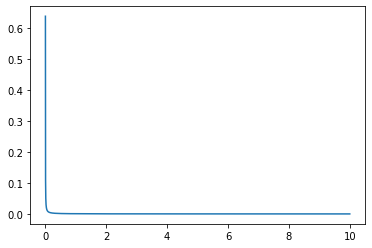

In [35]:
plt.plot(time,cost)

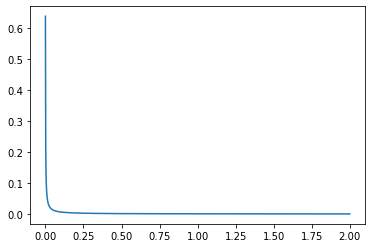

In [36]:
plt.plot(time[0:2000],cost[0:2000])

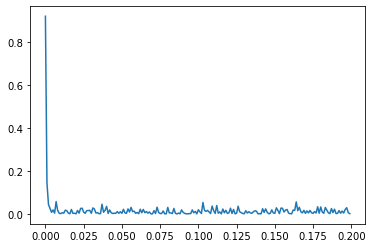

In [37]:
plt.plot(time[0:200],x_norm[0:200])

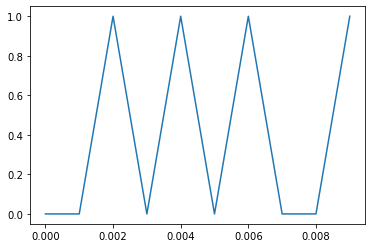

In [38]:
plt.plot(time[0:10],ms[0:10])

In [39]:
Final_Cost

0.0002124615779428708

In [40]:
#Ricatti Solver and testing the average cost with this

Opt_x_dynamics=np.zeros((2,time.shape[0]))
Opt_x_0=np.random.rand(2)
Opt_x_dynamics[:,0]=Opt_x_0
Opt_x_dynamics
Opt_cost=np.zeros((time.shape[0]))
Opt_x_norm=np.zeros((time.shape[0]))

## Opt_c_0=Opt_x_0.dot((Q.dot(Opt_x_0)))+Opt_u_0.dot((R.dot(Opt_u_0))) This line will appear after we have Opt_u_0 from K_0 after Dynamic Programming


In [41]:
# Dynamic Programming for Riccati Solver Policies as in Vijay Gupta's MJLS notes: http://www.cds.caltech.edu/~murray/books/AM08/pdf/ncs-markjls_22Jan10.pdf


P1=np.zeros((time.shape[0],2,2))
K1=np.zeros((time.shape[0],2,2))
P2=np.zeros((time.shape[0],2,2))
K2=np.zeros((time.shape[0],2,2))
#zero_init=np.zeros((2,2))
for t in range((time.shape[0])):
    P1[t]=np.zeros((2,2))
    P2[t]=np.zeros((2,2))
    K1[t]=np.zeros((2,2))
    K2[t]=np.zeros((2,2))
P1[time.shape[0]-1]=Q
P2[time.shape[0]-1]=Q
K1[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B1.T,Q),B1)),B1.T),Q),A1)
K2[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B2.T,Q),B2)),B2.T),Q),A2)

for t in range(1,time.shape[0]):
    P1[time.shape[0]-t-1]=p*(Q+np.dot(A1.T,np.dot(P1[time.shape[0]-t],A1))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A1.T,P1[time.shape[0]-t].T),B1),np.linalg.inv(R+np.dot(B1.T,np.dot(P1[time.shape[0]-t],B1)))),B1.T),P1[time.shape[0]-t]),A1))+(1-p)*(Q+np.dot(A2.T,np.dot(P2[time.shape[0]-t],A2))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A2.T,P2[time.shape[0]-t].T),B2),np.linalg.inv(R+np.dot(B2.T,np.dot(P2[time.shape[0]-t],B2)))),B2.T),P2[time.shape[0]-t]),A2))
    P2[time.shape[0]-t-1]=(1-q)*(Q+np.dot(A1.T,np.dot(P1[time.shape[0]-t],A1))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A1.T,P1[time.shape[0]-t].T),B1),np.linalg.inv(R+np.dot(B1.T,np.dot(P1[time.shape[0]-t],B1)))),B1.T),P1[time.shape[0]-t]),A1))+q*(Q+np.dot(A2.T,np.dot(P2[time.shape[0]-t],A2))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A2.T,P2[time.shape[0]-t].T),B2),np.linalg.inv(R+np.dot(B2.T,np.dot(P2[time.shape[0]-t],B2)))),B2.T),P2[time.shape[0]-t]),A2))
    K1[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B1.T,P1[time.shape[0]-t]),B1)),B1.T),P1[time.shape[0]-t]),A1)
    K2[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B2.T,P1[time.shape[0]-t]),B2)),B2.T),P2[time.shape[0]-t]),A2)


In [42]:
#Now we run the Riccati Optimal Policies

#First some initializations

markov_state=0
Opt_ms=np.zeros((time.shape[0]))
Opt_ms[0]=0

Opt_u_0= -K1[0].dot(Opt_x_0)

Opt_c_0=Opt_x_0.dot((Q.dot(Opt_x_0)))+Opt_u_0.dot((R.dot(Opt_u_0)))

Opt_cost[0]=Opt_c_0
Opt_x_norm[0]=LA.norm(Opt_x_0,2)

#Now we simulate the Markov Jump Dynamical System, this time playing optimally using Riccati Policies

for t in range(1,time.shape[0]):
    xprev=Opt_x_dynamics[:,t-1]
    markov_state=Opt_ms[t-1]
    if (markov_state==0):
        uprev=-K1[t-1].dot(xprev)
        markov_state=np.random.choice(2,1,p=[p,1-p])
    else:
        uprev=-K2[t-1].dot(xprev)
        markov_state=np.random.choice(2,1,p=[1-q,q])    
    if (markov_state==0):
        xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,var1,xprev.shape)
        ut=-K1[t].dot(xt)
    else:
        xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,var2,xprev.shape)
        ut=-K2[t].dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(Opt_cost[t-1]*(t)+ct)/(t+1)
    Opt_x_norm[t]=LA.norm(xt,2)
    Opt_cost[t]=c
    Opt_ms[t]=markov_state
    Opt_x_dynamics[:,t]=xt

Opt_Final_Cost=(Opt_cost[time.shape[0]-1]*(time.shape[0])+Opt_x_dynamics[:,time.shape[0]-1].dot(Q.dot(Opt_x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)



In [43]:
Opt_Final_Cost

0.00019178045301736078

In [44]:
Final_Cost

0.0002124615779428708